# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pynektools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import Field, FieldRegistry

# Readers
from pynektools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pynektools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '/home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001'
#fname = '/home/adperez/Documents/gaussian_process/Gaussian Process_0823/data/turbPipe/turbPipe0.f00001'


## Read the data

In [3]:
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)

pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)

for e in range(msh.nelv):
    if (np.min(msh.x[e]), np.max(msh.x[e])) == (0, 0.25):
        if (np.min(msh.y[e]), np.max(msh.y[e])) == (0, 1.1399999856948853):
            print(e)
    
coef = Coef(msh=msh, comm=comm)

2025-02-21 17:39:21,475 - Mesh - INFO - Initializing empty Mesh object.
2025-02-21 17:39:21,476 - Field - INFO - Initializing empty Field object
2025-02-21 17:39:21,477 - pynekread - INFO - Reading file: /home/adperez/cpc_gaussian_process_compression/data/mixlay/mixlay0.f00001
2025-02-21 17:39:21,484 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-21 17:39:21,485 - Mesh - INFO - Initializing common attributes.
2025-02-21 17:39:21,485 - Mesh - INFO - Getting vertices
2025-02-21 17:39:21,486 - Mesh - INFO - Getting edge centers
2025-02-21 17:39:21,493 - Mesh - INFO - Facet centers not available for 2D
2025-02-21 17:39:21,494 - Mesh - INFO - Mesh object initialized.
2025-02-21 17:39:21,494 - Mesh - INFO - Mesh data is of type: float64
2025-02-21 17:39:21,495 - Mesh - INFO - Elapsed time: 0.010787731999999998s
2025-02-21 17:39:21,495 - pynekread - INFO - Reading field data
2025-02-21 17:39:21,500 - pynekread - INFO - File read
2025-02-21 17:39:21,501 - pynekread - INF

## Compress the data with GPR

### Initialize the Direct sampler

In [4]:
from pynektools.compression.gpc_direct_sampling import DirectSampler

ds = DirectSampler(comm=comm, msh=msh, coef=coef)

### Sample the data

In [5]:
ds.log.tic()

# Select the options
n_samples = 1
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)

# Sample here
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="svd", compression_method="fixed_bitrate", bitrate = bitrate, covariance_keep_modes=1)
#ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=int(msh.nelv/16), compression_method="fixed_bitrate", bitrate = bitrate)
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=msh.nelv, compression_method="fixed_bitrate", bitrate = bitrate)

ds.log.toc()

2025-02-21 17:39:21,585 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-21 17:39:21,586 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-21 17:39:21,587 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-21 17:39:21,591 - DirectSampler - INFO - Estimating the covariance matrix using the averaging method method. Averaging over 1600 elements at a time
2025-02-21 17:39:21,592 - DirectSampler - INFO - Covariance saved in field data_to_compress["u"]["kw"]
2025-02-21 17:39:21,593 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.015625), 'n_samples': 1}
2025-02-21 17:39:21,594 - DirectSampler - INFO - Proccesing up to 256/1600 element
2025-02-21 17:39:21,595 - DirectSampler - INFO - Obtaining sample 1/1
2025-02-21 17:39:21,605 - DirectSampler - INFO - Procce

### Encode it

In [6]:
ds.compress_samples(lossless_compressor="bzip2")

2025-02-21 17:39:21,657 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-21 17:39:21,659 - DirectSampler - INFO - Compressing data in data_to_compress
2025-02-21 17:39:21,659 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-21 17:39:21,660 - DirectSampler - INFO - Compressing ["kw"] for field ["u"]
2025-02-21 17:39:21,660 - DirectSampler - INFO - Compressing ["field"] for field ["u"]


### Write it out

In [7]:
print(ds.compressed_data.items())

dict_items([('u', {'kw': b'BZh91AY&SY\xe7f\x1b:\x00\x00\xc7\x7f\xff\xff}\xde\xff\xbf{\xea\xb7\xf7\xd5\xe7\xdb\xfe\xff\xfb\xb7\xab\xb9\xfeu\x7f\xff\xff\xff\xff\xdf\xff\xde\xff\xfc\xea\xfb\xb0\x01{i\r\x19F\x9a\x1e\x91\xea\x00\x1a\r4\x06\x83F\x80\x00\x03A\xa0\x00\x00\x01\xa3@\x00\x00\x00\x00\x00\x01\xa1\x884\x00\x06@\xf4\x86@\xd1\xb544:4\x0c\x08\x00\x00\x06\x80\x1a\x1a\x1bH\x004h4h\x00h=F\x86\x80\x06\x99\x00\xd1\xa0\x03@h\x00\x00h\x00\x0fP\x00\xf5\x00\x19\x01U2\x00\r\x00\x00i\xa1\xa7\xa8\x06\x86\x81\x90\x1a\x03C@\r\x00\x06@\x00\x1a\x00\x01\x91\x90\x01\xa0\x00\x1a\x00\x01\xa6\x80\x00z\x81\xa0\xf5\x0e\xf8\x91"\x01A3\x0b\xc9J\xe0\x1c\x8b\xa6f\xc4"\xd5\x81\xa3\x1d\xe8\xe1\xa4\xba\x7f<~\xe7u\xe6(e\xc9\x96S\xa2ywD\xed\xd4=\x80azd\x84\x1a\xc5\x98R\x96u\x9fB|YbG\x0f\x13\xfc\xaa8b\x0b\xa0i,\xc2\x07\x97\x02\xa7\xdc\xf6\x92\x18#\x0bl\x13*\xd7!\xd0#\t\x12\x03f\xad\'d\t\xab\xca\xbc\x8f\x86+\xa6j}\xb1L\x97\xb0Ra\x85\xf5P\xf1\xe8`\xc8\x1b\x99}GH\x9cDtq$\n)\xc8P\x9b\xe6\x08\x03>dKF\xf4\x91\x10\x8f\xcc\xd

In [8]:
ds.write_compressed_samples(comm=comm, filename="test")

2025-02-21 17:39:21,836 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.


In [9]:
print(ds.settings)

{'mesh_information': {'lx': np.int64(8), 'ly': np.int64(8), 'lz': np.int64(1), 'nelv': np.int64(1600)}, 'covariance': {'method': 'average', 'elements_to_average': np.int64(1600), 'averages': 1, 'kw_diag': True}, 'compression': {'method': 'fixed_bitrate', 'bitrate': np.float64(0.015625), 'n_samples': 1}}


In [10]:
# Hack it a bit to make the rest work

ds.field = fld.registry["u"]
ds.field_sampled = ds.data_to_compress["u"]["field"]
#ds.kw = ds.data_to_compress["u"]["kw"]

averages = ds.settings["covariance"]["averages"]
elements_to_average = ds.settings["covariance"]["elements_to_average"]

if ds.settings["covariance"]["method"] == "svd":
    # Retrieve the SVD components
    U = ds.data_to_compress[f"u"]["U"]
    s = ds.data_to_compress[f"u"]["s"]
    Vt = ds.data_to_compress[f"u"]["Vt"]

    # Construct the f_hat
    f_hat = np.einsum("ik,k,kj->ij", U, s, Vt)

    # This is the way in which I calculate the covariance here and then get the diagonals
    if ds.kw_diag == True:
        # Get the covariances
        kw_ = np.einsum("eik,ekj->eij", f_hat.reshape(averages*elements_to_average,-1,1), f_hat.reshape(averages*elements_to_average,-1,1).transpose(0,2,1))
        # Extract only the diagonals
        kw_ = np.einsum("...ii->...i", kw_)
        
    else:
        # But I can leave the calculation of the covariance itself for later and store here the average of field_hat
        kw_ = f_hat.reshape(averages*elements_to_average,-1,1)

    ds.kw = kw_

else:
    ds.kw = ds.data_to_compress[f"u"]["kw"]



print(ds.kw.shape)

ds.elements_to_average = ds.settings["covariance"]["elements_to_average"]
ds.n_samples = ds.settings["compression"]["n_samples"]

(1, 64)


In [11]:
ind_50 = np.where(ds.field_sampled[0] == -50)
#print(ds.field[0])
#print(ds.field_sampled[0])
a = abs(ds.field_sampled[0])-abs(ds.field[0])
a[ind_50] = -50
print(a)

for e in range(msh.nelv):
    ind_50 = np.where(ds.field_sampled[e] == -50)
    if len(ind_50[0]) > n_samples:
        print(e, len(ind_50[0]))

[[[  0. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]
  [-50. -50. -50. -50. -50. -50. -50. -50.]]]
0 63
1 63
2 63
3 63
4 63
5 63
6 63
7 63
8 63
9 63
10 63
11 63
12 63
13 63
14 63
15 63
16 63
17 63
18 63
19 63
20 63
21 63
22 63
23 63
24 63
25 63
26 63
27 63
28 63
29 63
30 63
31 63
32 63
33 63
34 63
35 63
36 63
37 63
38 63
39 63
40 63
41 63
42 63
43 63
44 63
45 63
46 63
47 63
48 63
49 63
50 63
51 63
52 63
53 63
54 63
55 63
56 63
57 63
58 63
59 63
60 63
61 63
62 63
63 63
64 63
65 63
66 63
67 63
68 63
69 63
70 63
71 63
72 63
73 63
74 63
75 63
76 63
77 63
78 63
79 63
80 63
81 63
82 63
83 63
84 63
85 63
86 63
87 63
88 63
89 63
90 63
91 63
92 63
93 63
94 63
95 63
96 63
97 63
98 63
99 63
100 63
101 63
102 63
103 63
104 63
105 63
106 63
107 63


In [12]:

print(ds.field_hat[1466].reshape(-1,1, order='F'))

print("======")

print(ds.field_sampled[1466].reshape(-1,1, order='F'))

[[ 1.99990441e-01]
 [-5.57531503e-06]
 [-1.80462288e-08]
 [ 7.00211732e-09]
 [-9.51879178e-09]
 [ 2.13566155e-09]
 [-5.95115817e-10]
 [-5.36121616e-10]
 [-8.59488645e-06]
 [-5.00078505e-06]
 [-3.83074439e-09]
 [ 8.52690949e-09]
 [-8.40598942e-09]
 [ 2.39046847e-09]
 [-8.58811016e-10]
 [-2.42388614e-10]
 [-2.37776126e-06]
 [-1.36844321e-06]
 [ 1.57842481e-08]
 [ 5.69112633e-09]
 [-2.72724125e-09]
 [ 4.27633113e-10]
 [-4.92429909e-10]
 [ 4.96550225e-10]
 [ 1.13080070e-07]
 [ 7.57060759e-08]
 [ 1.00539981e-08]
 [ 8.09318145e-10]
 [-2.86645941e-10]
 [ 2.32829433e-10]
 [ 1.42264199e-10]
 [ 4.43830162e-10]
 [ 8.43976818e-08]
 [ 4.96585829e-08]
 [-1.09479314e-09]
 [ 8.54305353e-10]
 [ 9.55948182e-10]
 [-8.39331422e-10]
 [ 3.69644683e-10]
 [ 2.50419075e-10]
 [-1.66313403e-08]
 [-1.06633414e-08]
 [-2.55425789e-09]
 [-9.41682210e-11]
 [ 1.41116511e-09]
 [-6.89430439e-10]
 [ 6.21008604e-11]
 [ 1.17915297e-09]
 [-4.47323203e-09]
 [-2.63863014e-09]
 [-1.17943747e-09]
 [-1.12387309e-09]
 [ 1.3693124

In [13]:
recon = ds.predict(ds.field_sampled)

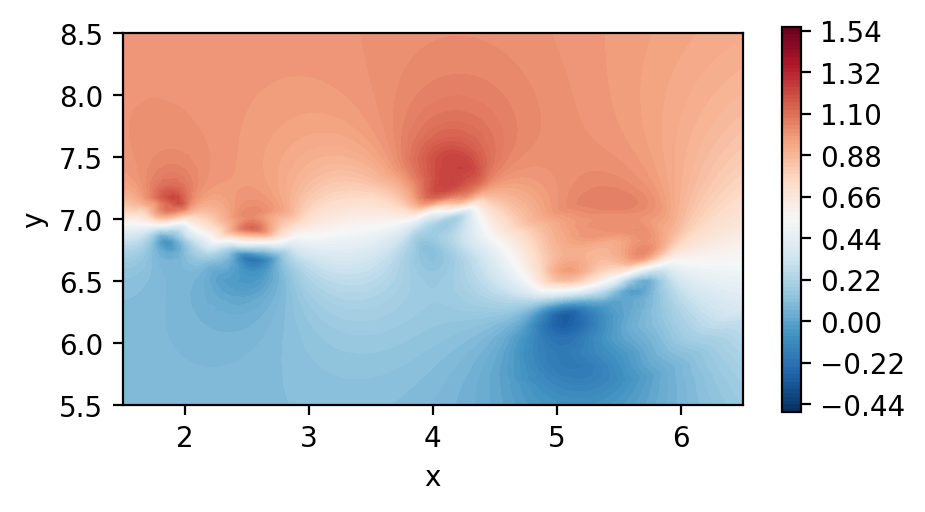

In [14]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

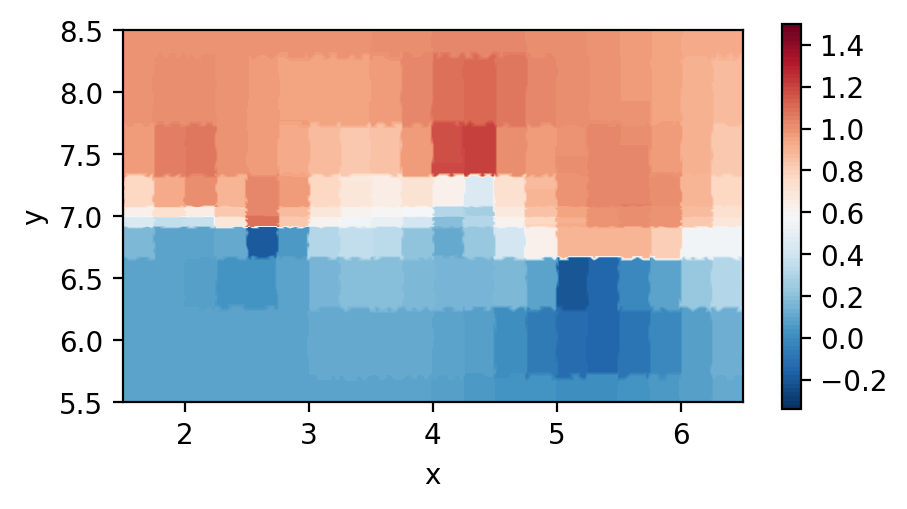

In [15]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
#c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() , fld.registry["u"].flatten() - recon.flatten(), levels=100, cmap="RdBu_r")
c = ax.tricontourf(msh.x.flatten(), msh.y.flatten() ,recon.flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

In [16]:
print(np.mean(fld.registry["u"] - recon))
print(np.max(abs(fld.registry["u"] - recon)))
print(np.min(abs(fld.registry["u"] - recon)))

0.023300941236072115
1.2996516558938238
0.0


In [17]:
print(ds.settings)

{'mesh_information': {'lx': np.int64(8), 'ly': np.int64(8), 'lz': np.int64(1), 'nelv': np.int64(1600)}, 'covariance': {'method': 'average', 'elements_to_average': np.int64(1600), 'averages': 1, 'kw_diag': True}, 'compression': {'method': 'fixed_bitrate', 'bitrate': np.float64(0.015625), 'n_samples': 1}}
